Here we install OpenVDS+ from a pre-packaged Python Wheel

This file sits one directory below our Jupyter Notebook

In [1]:
%pip install ./openvds_install/openvds-2.0.2-cp36-cp36m-linux_x86_64.whl

Processing ./openvds_install/openvds-2.0.2-cp36-cp36m-linux_x86_64.whl
Note: you may need to restart the kernel to use updated packages.


Let's try to import OpenVDS, and we get an error about the boost libraries missing.
**This is specific to Linux/SageMaker ONLY. On windows you won't get this error**

In [2]:
import openvds

ImportError: libboost_system.so.1.69.0: cannot open shared object file: No such file or directory

This error happens because OpenVDS depends on the boost libraries, and it is not installed by default on SageMaker instances.

We get the Conda environment path from the environment variable `CONDA_PREFIX`.

We also get the boost-1.69 shared libraries we compiled from source and they are located in the `boost_lib` variable.

In [3]:
import os

env_path = os.environ['CONDA_PREFIX'] 
boost_lib = "~/SageMaker/altay_scratch/openvds_install/boost_1_69_0_libs/*"

from os import path
env_lib_path = path.join(env_path, 'lib')

print('Copy from:\t', boost_lib)
print('Copy to:\t', env_lib_path)

Copy from:	 ~/SageMaker/altay_scratch/openvds_install/boost_1_69_0_libs/*
Copy to:	 /home/ec2-user/anaconda3/envs/tensorflow_p36/lib


Now we can run a copy `cp` command in shell that takes pre-compiled shared libraries to our environment so OpenVDS can use it.

In [4]:
!cp $boost_lib $env_lib_path

If we try to import again, we will see it doesn't give us that error.

In [5]:
import openvds

In [6]:
from os import getenv
from time import time

from vds_utils import (
    get_minicube,
    get_slice,
    print_channel_info,
    print_crs_metadata,
)

In [7]:
%reload_ext dotenv
%dotenv

region = 'us-east-1'
aws_key = getenv('AWS_ACCESS_KEY_ID')
aws_secret = getenv('AWS_SECRET_ACCESS_KEY')

region_config = f"Region={region}"
key_config = f"AccessKeyId={aws_key}"
secret_config = f"SecretKey={aws_secret}"

aws_config = ';'.join([
    region_config,
    key_config,
    secret_config,
])

In [8]:

# vds_url = r's3://geophysics-on-cloud/poseidon/seismic/vds/psdn11_TbsdmF_Near_Nov_11_32bit/'
# vds_url = r's3://geophysics-on-cloud/poseidon/seismic/vds/psdn11_TbsdmF_Mid_Nov_11_32bit/'
# vds_url = r's3://geophysics-on-cloud/poseidon/seismic/vds/psdn11_TbsdmF_Far_Nov_11_32bit/'
vds_url = r's3://geophysics-on-cloud/poseidon/seismic/vds/psdn11_TbsdmF_full_w_AGC_Nov11/'

vds_handle = openvds.open(
    url=vds_url,
    connectionString=aws_config,
)

layout = openvds.getLayout(vds_handle)

print_channel_info(layout)
print_crs_metadata(layout)

ChannelCount: 3
  Channel Name: Amplitude
    Value range: -15334.1142578125 - 15334.1142578125
  Channel Name: Trace
    Value range: 0.0 - 256.0
  Channel Name: SEGYTraceHeader
    Value range: 0.0 - 256.0
Dimensionality: 3
  Dimension name: Sample
    Number of samples: 1501
    Coordinate min max 0.0 - 6000.0
  Dimension name: Crossline
    Number of samples: 5053
    Coordinate min max 504.0 - 5556.0
  Dimension name: Inline
    Number of samples: 3437
    Coordinate min max 983.0 - 4419.0
SurveyCoordinateSystem::Origin: (409110.54968723457, 8429425.04864461)
SurveyCoordinateSystem::InlineSpacing: (12.052651580247169, 14.363472429446059)
SurveyCoordinateSystem::CrosslineSpacing: (-9.57557031868567, 8.035035629453683)


In [9]:
access_manager = openvds.VolumeDataAccessManager(vds_handle)


In [10]:
t0 = time()

il_range = (2550, 2650)
xl_range = (2950, 3050)
z_range = (2000, 4000)

mini_cube = get_minicube(
    access_manager=access_manager,
    layout=layout,
    il_range=il_range,
    xl_range=xl_range,
    z_range=z_range,
)

print(f"Retreived minicube in {time() - t0:.2f} seconds.")
print("Shape of minicube", mini_cube.shape)

Retreived minicube in 1.51 seconds.
Shape of minicube (101, 101, 501)


In [11]:
import matplotlib.pyplot as plt
import numpy as np

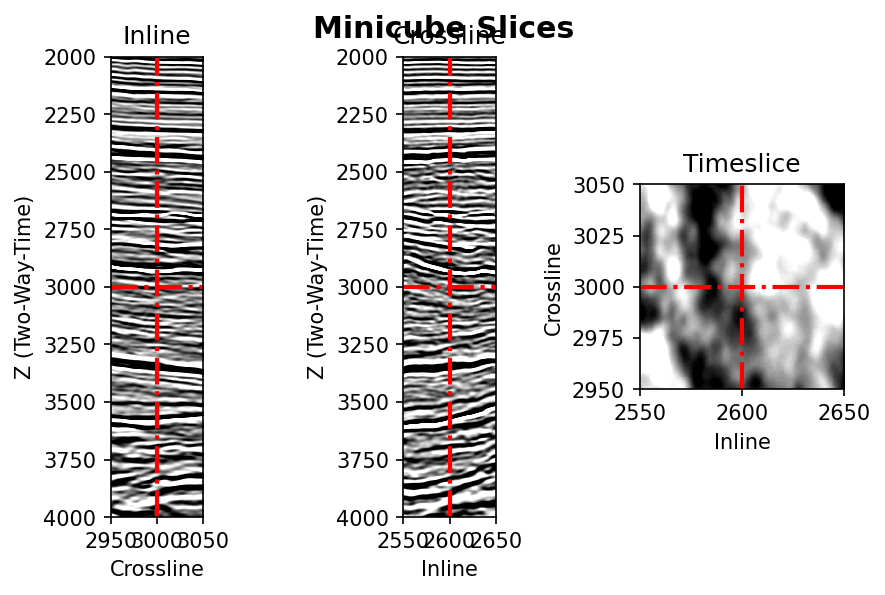

In [12]:
fig, (ax_il, ax_xl, ax_z) = plt.subplots(1, 3, dpi=150)

image_kwargs = {
    'vmin': -5250,
    'vmax': 5250,
    'cmap': 'gray',
}

line_kwargs = {
    'color': 'red',
    'linewidth': 2,
    'linestyle': '-.',
}

n_il, n_xl, n_z = mini_cube.shape
ax_il.imshow(mini_cube[n_il // 2, :, :].T, extent=[*xl_range, *z_range[::-1]], aspect=0.25, **image_kwargs)
ax_il.axvline(np.mean(xl_range), **line_kwargs)
ax_il.axhline(np.mean(z_range), **line_kwargs)
ax_il.set_xlabel('Crossline')
ax_il.set_ylabel('Z (Two-Way-Time)')
ax_il.set_title('Inline')

ax_xl.imshow(mini_cube[:, n_xl // 2, :].T, extent=[*il_range, *z_range[::-1]], aspect=0.25, **image_kwargs)
ax_xl.axvline(np.mean(il_range), **line_kwargs)
ax_xl.axhline(np.mean(z_range), **line_kwargs)
ax_xl.set_xlabel('Inline')
ax_xl.set_ylabel('Z (Two-Way-Time)')
ax_xl.set_title('Crossline')

ax_z.imshow(mini_cube[:, :, n_z // 2].T, extent=[*il_range, *xl_range], aspect=1, origin='lower', **image_kwargs)
ax_z.axhline(np.mean(xl_range), **line_kwargs)
ax_z.axvline(np.mean(il_range), **line_kwargs)
ax_z.set_xlabel('Inline')
ax_z.set_ylabel('Crossline')
ax_z.set_title('Timeslice')

fig.suptitle("Minicube Slices", size='x-large', weight='bold')
fig.tight_layout()